In [1]:
!pip install findspark
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Colab PySpark Example") \
    .getOrCreate()

In [ ]:
df = spark.read.csv("sales_dataset.csv", header=True, inferSchema=True)
display(df)


DataFrame[Row ID: int, Order ID: string, Order Date: string, Ship Date: string, Ship Mode: string, Customer ID: string, Customer Name: string, Segment: string, Country: string, City: string, State: string, Postal Code: int, Region: string, Product ID: string, Category: string, Sub-Category: string, Product Name: string, Sales: string]

In [6]:
df.show()

+------+--------------+----------+----------+--------------+-----------+------------------+-----------+-------------+---------------+--------------+-----------+-------+---------------+---------------+------------+--------------------+--------+
|Row ID|      Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|     Customer Name|    Segment|      Country|           City|         State|Postal Code| Region|     Product ID|       Category|Sub-Category|        Product Name|   Sales|
+------+--------------+----------+----------+--------------+-----------+------------------+-----------+-------------+---------------+--------------+-----------+-------+---------------+---------------+------------+--------------------+--------+
|     1|CA-2017-152156|08/11/2017|11/11/2017|  Second Class|   CG-12520|       Claire Gute|   Consumer|United States|      Henderson|      Kentucky|      42420|  South|FUR-BO-10001798|      Furniture|   Bookcases|Bush Somerset Col...|  261.96|
|     2|CA-2017-152156|0

In [7]:
df.createOrReplaceTempView("sample")

1.count of total number of customers


In [18]:
spark.sql("SELECT count(distinct `customer ID`)from sample").show()

+---------------------------+
|count(DISTINCT customer ID)|
+---------------------------+
|                        793|
+---------------------------+



2.order on weekly and monthly basis

In [9]:
spark.sql("SELECT count(distinct `customer ID`) from sample where `Order Date` between '2016-10-11' and '2017-11-08'").show()

+---------------------------+
|count(DISTINCT customer ID)|
+---------------------------+
|                          0|
+---------------------------+



You can change the value of the `time_period` variable in the code cell below to switch between 'Weekly' and 'Monthly' analysis.

In [11]:
time_period = 'Weekly' # Change this to 'Monthly' to analyze data monthly
print(f"Time period selected: {time_period}")

Time period selected: Weekly


for dropdown list we have to install the ipywidgets


In [12]:
# Install ipywidgets if not installed
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.5 MB/s eta 0:00:00


For start monthly and weekly basis date

In [19]:
from datetime import date, timedelta
import ipywidgets as widgets
from IPython.display import display

# Global variables (initialized as None)
start_date, end_date = None, None

# Create dropdown widget
time_period_dropdown = widgets.Dropdown(
    options=['Weekly', 'Monthly'],
    value='Weekly',
    description='Time Period:',
)

display(time_period_dropdown)

def calculate_dates(change=None):
    global start_date, end_date   # make them accessible outside the function

    time_period = time_period_dropdown.value
    print("Selected:", time_period)

    today = date.today()

    if time_period.lower() == 'weekly':
        start_date = today - timedelta(days=today.weekday(), weeks=1) - timedelta(days=1)
        end_date = start_date + timedelta(days=6)
    else:
        first = today.replace(day=1)
        end_date = first - timedelta(days=1)
        start_date = first - timedelta(days=end_date.day)

    print("Start Date:", start_date)
    print("End Date:", end_date)

# Attach event listener so when you change dropdown, function runs
time_period_dropdown.observe(calculate_dates, names='value')

# Run once initially
calculate_dates()

# Now these variables exist globally
start_date_str = start_date.strftime("%Y-%m-%d")
end_date_str = end_date.strftime("%Y-%m-%d")




Dropdown(description='Time Period:', options=('Weekly', 'Monthly'), value='Weekly')

Selected: Weekly
Start Date: 2025-08-10
End Date: 2025-08-16
Selected: Monthly
Start Date: 2025-07-01
End Date: 2025-07-31
Selected: Weekly
Start Date: 2025-08-10
End Date: 2025-08-16


In [24]:


result_df=spark.sql(f"""SELECT count(distinct `customer ID`) from sample where `Order Date` between '{start_date_str}' and '{end_date_str}'""")
result_df.show()

+---------------------------+
|count(DISTINCT customer ID)|
+---------------------------+
|                          0|
+---------------------------+



3.total number of order

In [25]:
spark.sql("SELECT count(distinct `Order ID`)from sample").show()

+------------------------+
|count(DISTINCT Order ID)|
+------------------------+
|                    4922|
+------------------------+



4.Total number of oredrs on perticular month or week

In [27]:


result_df1=spark.sql(f"""SELECT count(distinct `customer ID`) from sample where `Order Date` between '{start_date_str}' and '{end_date_str}'""")
result_df1.show()

+---------------------------+
|count(DISTINCT customer ID)|
+---------------------------+
|                          0|
+---------------------------+



5.total sales and profit

In [ ]:
#sale and profit columns not present in this dataset
spark.sql("SELECT sum(`sales`), sum('profit')from sample").show()

6.Top sales by country

In [29]:
top_sales_bycountry=spark.sql("""
    SELECT Country, SUM(Sales) as total_sales
    FROM sample
    GROUP BY Country
""")
top_sales_bycountry.show()

+-------------+------------------+
|      Country|       total_sales|
+-------------+------------------+
|United States|2237133.1626999523|
+-------------+------------------+



7.Most profitable region/country

In [37]:
top_region = spark.sql("""
    SELECT Country, Region, SUM(Sales) as total_sales
    FROM sample
    GROUP BY Country, Region
    ORDER BY total_sales DESC
""")

top_region.show()



+-------------+-------+------------------+
|      Country| Region|       total_sales|
+-------------+-------+------------------+
|United States|   West| 698354.7745000002|
|United States|   East| 663043.8579999986|
|United States|Central|489321.39120000065|
|United States|  South|386413.13900000043|
+-------------+-------+------------------+



Top sales category

In [39]:
top_sales_category = spark.sql("""
    SELECT SUM(Sales) , Category as total_category
    FROM sample
    GROUP BY Category
    ORDER BY total_category DESC
""")

top_sales_category.show()


+-----------------+---------------+
|       sum(Sales)| total_category|
+-----------------+---------------+
|827201.9069999964|     Technology|
|690139.8000000035|Office Supplies|
|719791.4556999996|      Furniture|
+-----------------+---------------+



top 10 Subcategory


In [47]:
top_sales_subcategory = spark.sql("""
    SELECT 'Sub-Category' as subcategory , SUM(sales) as totalsales
    FROM sample
    GROUP BY 'Sub-Category'
    ORDER BY totalsales DESC
    limit 10
""")

top_sales_subcategory.show()

+------------+------------------+
| subcategory|        totalsales|
+------------+------------------+
|Sub-Category|2237133.1626999523|
+------------+------------------+



In [54]:
sales_data_byName = spark.sql("""
SELECT `Customer Name` as CustomerName , `Product Name` as ProductName
From sample
""")

sales_data_byName.show()

+------------------+--------------------+
|      CustomerName|         ProductName|
+------------------+--------------------+
|       Claire Gute|Bush Somerset Col...|
|       Claire Gute|Hon Deluxe Fabric...|
|   Darrin Van Huff|Self-Adhesive Add...|
|    Sean O'Donnell|Bretford CR4500 S...|
|    Sean O'Donnell|Eldon Fold 'N Rol...|
|   Brosina Hoffman|Eldon Expressions...|
|   Brosina Hoffman|          Newell 322|
|   Brosina Hoffman|Mitel 5320 IP Pho...|
|   Brosina Hoffman|DXL Angle-View Bi...|
|   Brosina Hoffman|Belkin F5C206VTEL...|
|   Brosina Hoffman|Chromcraft Rectan...|
|   Brosina Hoffman|Konftel 250 Confe...|
|      Andrew Allen|          Xerox 1967|
|      Irene Maddox|Fellowes PB200 Pl...|
|     Harold Pawlan|Holmes Replacemen...|
|     Harold Pawlan|Storex DuraTech R...|
|         Pete Kriz|"Stur-D-Stor Shel...|
|   Alejandro Grove|Fellowes Super St...|
|Zuschuss Donatelli|          Newell 341|
|Zuschuss Donatelli|Cisco SPA 501G IP...|
+------------------+--------------

Top customer

In [59]:
top_customer = spark.sql("""
SELECT `Customer Name` as CustomerName,  sum(sales) as Sales , City
from sample
group by `Customer Name` , City
""")
top_customer.show()

+-----------------+------------------+--------------+
|     CustomerName|             Sales|          City|
+-----------------+------------------+--------------+
|      Lisa Hazard|            51.184|         Tyler|
|     Joseph Airdo|            34.344|       Phoenix|
|    Raymond Messe|            215.65|      San Jose|
|        Max Engle|            62.132|       Seattle|
|    Jennifer Patt|25.951999999999998|     Oceanside|
|      Scot Wooten|            53.344|   Springfield|
|     Ben Peterman|            101.12|       Anaheim|
|        Don Jones|             91.14|    Woonsocket|
|  Thomas Thornton|            182.91|Virginia Beach|
|    Kelly Lampkin|            204.55|  Fayetteville|
|     Bart Pistole|            829.83|      Lawrence|
|       Dan Lawera|              NULL|         Miami|
|     Fred Hopkins|176.59199999999998|   Los Angeles|
|  Tracy Blumstein|           130.756|      Beaumont|
| Jonathan Doherty|            199.18|      Columbia|
|   Linda Cazamias|         

Top sales visulization

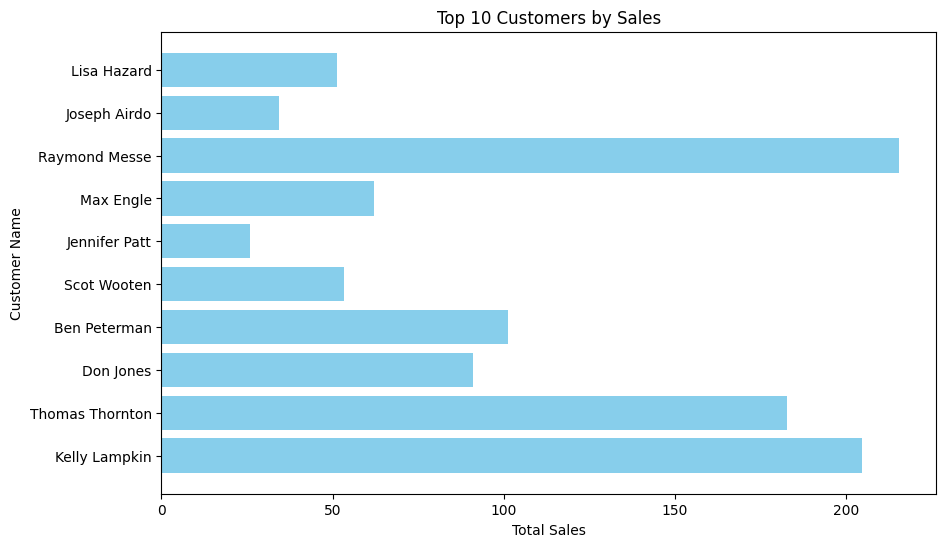

In [61]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame → Pandas
top_customer_pd = top_customer.toPandas()

# Plot top 10 customers by sales
top10 = top_customer_pd.head(10)

plt.figure(figsize=(10,6))
plt.barh(top10['CustomerName'], top10['Sales'], color='skyblue')
plt.gca().invert_yaxis()  # biggest on top
plt.xlabel("Total Sales")
plt.ylabel("Customer Name")
plt.title("Top 10 Customers by Sales")
plt.show()